In [31]:
import os
participants_data_filename = "/home/martin/data_imaging/Muscle/data_sarcopenia_tx/Doc Unificado 30072025.xlsx"
pelvis_mri_results_path = "/home/martin/data_imaging/Muscle/data_sarcopenia_tx/nifti_pelvis/"
lumbar_mri_results_path = "/home/martin/data_imaging/Muscle/data_sarcopenia_tx/nifti_pelvis/"
output_path = "/home/martin/data_imaging/Muscle/data_sarcopenia_tx/statistical_analysis/"

participants_data_filename = "d:/data_sherpas/ParticipantsDemographics.xlsx"
pelvis_mri_results_path = "d:/data_sherpas/ProcessedCropped/"
lumbar_mri_results_path = "d:/data_sherpas/LumbarSpineProcessed/"
output_path = "d:/data_sherpas/statistical_analysis/"

volume_ff_filename_per_subject = "volumes_and_ffs.csv"
column_names_pelvis = ["VOL_LGMAX", "VOL_LGMED", "VOL_LGMIN", "VOL_LTFL", "VOL_RGMAX", "VOL_RGMED", "VOL_RGMIN", "VOL_RTFL",
                "FF_LGMAX", "FF_LGMED", "FF_LGMIN", "FF_LTFL", "FF_RGMAX", "FF_RGMED", "FF_RGMIN", "FF_RTFL"]
column_names_lumbar = ["VOL_LPSOAS", "VOL_LILIACUS", "VOL_LQUADRATUS", "VOL_LM+ES", "VOL_RPSOAS", "VOL_RILIACUS", "VOL_RQUADRATUS", "VOL_RM+ES",
                       "FF_LPSOAS", "FF_LILIACUS", "FF_LQUADRATUS", "FF_LM+ES", "FF_RPSOAS", "FF_RILIACUS", "FF_RQUADRATUS", "FF_RM+ES"]
os.makedirs(output_path, exist_ok=True)

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns   
import scipy.stats as stats

# Load the data
data = pd.read_excel(participants_data_filename, sheet_name='Sheet1')


In [32]:
import glob

# Get all subfolders in pelvis_mri_results_path
subfolders = [f.path for f in os.scandir(pelvis_mri_results_path) if f.is_dir()]
# For each subfolder, match to ID and add volume/ff data
for folder in subfolders:
    folder_name = os.path.basename(folder)
    # Find matching row in data
    idx = data.index[data['Code'] == folder_name]
    if not idx.empty:
        csv_path = os.path.join(folder, volume_ff_filename_per_subject)
        if os.path.exists(csv_path):
            vol_ff_df = pd.read_csv(csv_path, header=None)
            # Assuming single row, add columns to data
            for col in vol_ff_df.columns:
                # Assign values to named columns using column_names_pelvis
                if col > 0 and col <= len(column_names_pelvis):
                    data.loc[idx, column_names_pelvis[col-1]] = vol_ff_df.iloc[0][col]

# Do the same for lumbar results
subfolders = [f.path for f in os.scandir(lumbar_mri_results_path) if f.is_dir()]
# For each subfolder, match to ID and add volume/ff data
for folder in subfolders:
    folder_name = os.path.basename(folder)
    # Find matching row in data
    idx = data.index[data['Code'] == folder_name]
    if not idx.empty:
        csv_path = os.path.join(folder, volume_ff_filename_per_subject)
        if os.path.exists(csv_path):
            vol_ff_df = pd.read_csv(csv_path, header=None)
            # Assuming single row, add columns to data
            for col in vol_ff_df.columns:
                # Assign values to named columns using column_names_lumbar
                if col > 0 and col <= len(column_names_lumbar):
                    data.loc[idx, column_names_lumbar[col-1]] = vol_ff_df.iloc[0][col]

# Save the combined data to a new CSV file
combined_data_path = os.path.join(output_path, "combined_data.csv")
data.to_csv(combined_data_path, index=False)
print(f"Combined data saved to {combined_data_path}")

Combined data saved to d:/data_sherpas/statistical_analysis/combined_data.csv


In [33]:
muscles = ['GMAX', 'GMED', 'GMIN', 'TFL', 'PSOAS', 'ILIACUS', 'QUADRATUS', 'M+ES']
# Create filtered data with the subjects with valid data and correct naming:
filtered_data = data[data['VOL_LGMAX'].notna()].copy()
filtered_data.rename(columns={'Activity': 'Group'}, inplace=True)
# Add column for BMI
filtered_data['BMI'] = filtered_data['Weight'] / (filtered_data['Height']/100)**2
# Compute mean FF and Volume for each muscle (averaging left and right)
for muscle in muscles:
    filtered_data[f'FF_{muscle}'] = (filtered_data[f'FF_L{muscle}'] + filtered_data[f'FF_R{muscle}']) / 2
    filtered_data[f'VOL_{muscle}'] = (filtered_data[f'VOL_L{muscle}'] + filtered_data[f'VOL_R{muscle}']) / 2
for muscle in muscles:
    filtered_data[f'NORM_VOL_{muscle}'] = filtered_data[f'VOL_{muscle}'] / filtered_data['Weight']
    # now lean normalised volume:
    filtered_data[f'LEAN_NORM_VOL_{muscle}'] = filtered_data[f'NORM_VOL_{muscle}'] * (1-filtered_data[f'FF_{muscle}'])
    # by height
    filtered_data[f'NORMH_VOL_{muscle}'] = filtered_data[f'VOL_{muscle}'] / filtered_data['Height']
    # now lean normalised volume:
    filtered_data[f'LEAN_NORMH_VOL_{muscle}'] = filtered_data[f'NORMH_VOL_{muscle}'] * (1-filtered_data[f'FF_{muscle}'])
    # by height squared
    filtered_data[f'NORMH2_VOL_{muscle}'] = filtered_data[f'VOL_{muscle}'] / filtered_data['Height']**2
    # now lean normalised volume:
    filtered_data[f'LEAN_NORMH2_VOL_{muscle}'] = filtered_data[f'NORMH2_VOL_{muscle}'] * (1-filtered_data[f'FF_{muscle}'])

ff_columns = [col for col in filtered_data.columns if col.startswith('FF_')]
filtered_data[ff_columns] = filtered_data[ff_columns] * 100

# Save csv with filtered data
filtered_data_path = os.path.join(output_path, "full_data_results_only_valid.csv")
filtered_data.to_csv(filtered_data_path, index=False)
print(f"Filtered data saved to {filtered_data_path}")
# If you want to convert volumes from mm^3 to cm^3, uncomment the following line:
#vol_columns = [col for col in filtered_data.columns if col.startswith('VOL_')]
#filtered_data[vol_columns] = filtered_data[vol_columns] / 1000  

Filtered data saved to d:/data_sherpas/statistical_analysis/full_data_results_only_valid.csv


In [34]:
# Compute demographics:
# Compute mean (SD) for age, BMI, years post-transplant, and years of dialysis for each group
group_stats = filtered_data.groupby('Group').agg(
    Age_Mean=('Age', 'mean'),
    Age_SD=('Age', 'std'),
    Age_Min=('Age', 'min'),
    Age_Max=('Age', 'max'),
    BMI_Mean=('BMI', 'mean'),
    BMI_SD=('BMI', 'std'),
    BMI_Min=('BMI', 'min'),
    BMI_Max=('BMI', 'max'),
    #Years_Post_Transplant_Mean=('¿Cuánto tiempo hizo diálisis antes de su trasplante?\nSi no hizo diálisis, indiquelo con un 0', 'mean'),
    #Years_Post_Transplant_SD=('¿Cuánto tiempo hizo diálisis antes de su trasplante?\nSi no hizo diálisis, indiquelo con un 0', 'std'),
    #Years_Dialysis_Mean=('¿Hace cuanto tiempo que realiza diálisis?', 'mean'),
    #Years_Dialysis_SD=('¿Hace cuanto tiempo que realiza diálisis?', 'std'),
    Subject_Count=('Code', 'count')
    , Male_Count=('Sex', lambda x: (x == 'Male').sum()),
    Female_Count=('Sex', lambda x: (x == 'Female').sum()),
    Male_Percentage=('Sex', lambda x: (x == 'Male').mean() * 100),
    Female_Percentage=('Sex', lambda x: (x == 'Female').mean() * 100)
)

# Print the computed statistics
print(group_stats)

        Age_Mean    Age_SD  Age_Min  Age_Max       BMI_Mean        BMI_SD  \
Group                                                                       
Porter     36.15  8.325278     21.0     55.0  250012.174125  25959.116825   

              BMI_Min        BMI_Max  Subject_Count  Male_Count  Female_Count  \
Group                                                                           
Porter  213039.485767  320512.820513             40          39             1   

        Male_Percentage  Female_Percentage  
Group                                       
Porter             97.5                2.5  


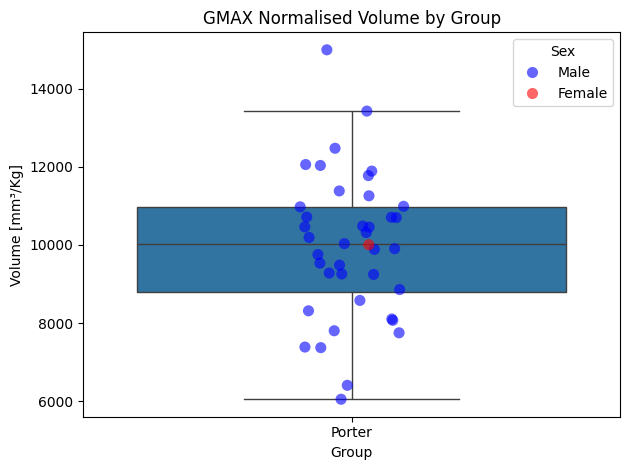

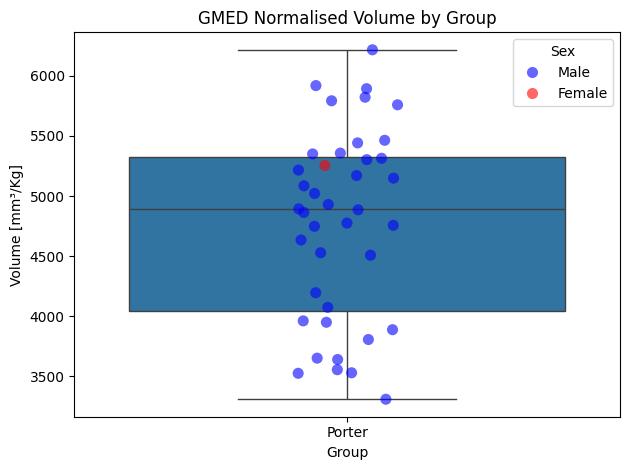

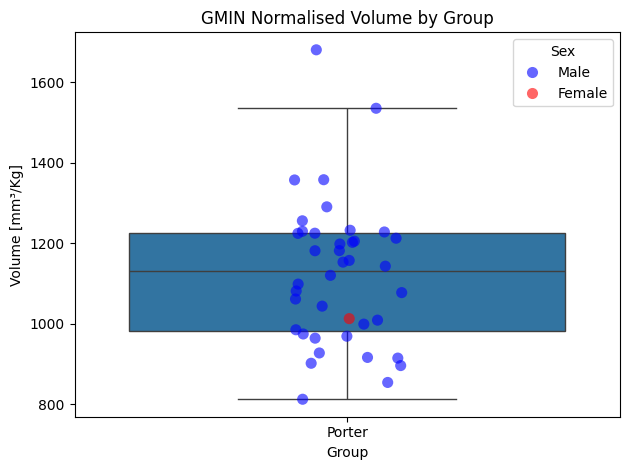

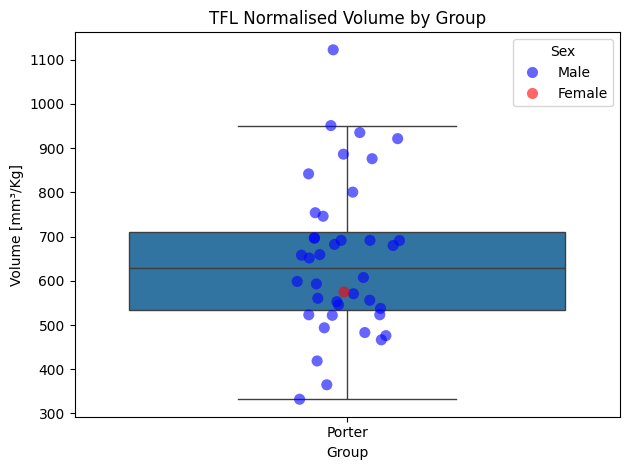

In [58]:
# Plot box plots for volume:

for muscle in ['GMAX', 'GMED', 'GMIN', 'TFL']:
    sns.boxplot(x='Group', y=f'NORM_VOL_{muscle}', data=filtered_data, showfliers=False)
    sns.stripplot(x='Group', y=f'NORM_VOL_{muscle}', data=filtered_data, hue='Sex', 
                  palette={'Male': 'blue', 'Female': 'red'}, alpha=0.6, jitter=True, size=8, 
                  marker='o' if filtered_data['Sex'].iloc[0] == 'Male' else 'X')
    plt.ylabel('Volume [mm³/Kg]')
    plt.title(f'{muscle} Normalised Volume by Group')
    #plt.ylim(0, 25)
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"boxplot_norm_vol_{muscle}_by_group.png"))
    plt.show()
    plt.close()


In [62]:
# CREATE MELTED DATAFRAME WITH ALL MUSCLES AND VARIABLES
# Create dataframes for each variable
ff_cols = [f'FF_{muscle}' for muscle in muscles]
vol_cols = [f'VOL_{muscle}' for muscle in muscles]
nvol_cols = [f'NORM_VOL_{muscle}' for muscle in muscles]
lnvol_cols = [f'LEAN_NORM_VOL_{muscle}' for muscle in muscles]
nhvol_cols = [f'NORMH_VOL_{muscle}' for muscle in muscles]
lnhvol_cols = [f'LEAN_NORMH_VOL_{muscle}' for muscle in muscles]
nh2vol_cols = [f'NORMH2_VOL_{muscle}' for muscle in muscles]
lnh2vol_cols = [f'LEAN_NORMH2_VOL_{muscle}' for muscle in muscles]
ff_df = filtered_data[ff_cols].copy()
vol_df = filtered_data[vol_cols].copy()
nvol_df = filtered_data[nvol_cols].copy()
lnvol_df = filtered_data[lnvol_cols].copy()
nhvol_df = filtered_data[nhvol_cols].copy()#
lnhvol_df = filtered_data[lnhvol_cols].copy()
nh2vol_df = filtered_data[nh2vol_cols].copy()
lnh2vol_df = filtered_data[lnh2vol_cols].copy()


# now melt all dataframes and concatenate them
# now melt it
ff_melted = ff_df.melt(var_name='Muscle', value_name='FF')
ff_melted['Muscle'] = ff_melted['Muscle'].str.replace('FF_', '')
vol_melted = vol_df.melt(var_name='Muscle', value_name='VOL')
vol_melted['Muscle'] = vol_melted['Muscle'].str.replace('VOL_', '')
nvol_melted = nvol_df.melt(var_name='Muscle', value_name='NORM_VOL')
nvol_melted['Muscle'] = nvol_melted['Muscle'].str.replace('NORM_VOL_', '')
lnvol_melted = lnvol_df.melt(var_name='Muscle', value_name='LEAN_NORM_VOL')
lnvol_melted['Muscle'] = lnvol_melted['Muscle'].str.replace('LEAN_NORM_VOL_', '')
nhvol_melted = nhvol_df.melt(var_name='Muscle', value_name='NORMH_VOL')
nhvol_melted['Muscle'] = nhvol_melted['Muscle'].str.replace('NORMH_VOL_', '')
lnhvol_melted = lnhvol_df.melt(var_name='Muscle', value_name='LEAN_NORMH_VOL')
lnhvol_melted['Muscle'] = lnhvol_melted['Muscle'].str.replace('LEAN_NORMH_VOL_', '')
nh2vol_melted = nh2vol_df.melt(var_name='Muscle', value_name='NORMH2_VOL')
nh2vol_melted['Muscle'] = nh2vol_melted['Muscle'].str.replace('NORMH2_VOL_', '')
lnh2vol_melted = lnh2vol_df.melt(var_name='Muscle', value_name='LEAN_NORMH2_VOL')
lnh2vol_melted['Muscle'] = lnh2vol_melted['Muscle'].str.replace('LEAN_NORMH2_VOL_', '')
# Concatenate all melted dataframes
all_melted = pd.concat([ff_melted, vol_melted['VOL'], nvol_melted['NORM_VOL'], lnvol_melted['LEAN_NORM_VOL'],
                        nhvol_melted['NORMH_VOL'], lnhvol_melted['LEAN_NORMH_VOL'],
                        nh2vol_melted['NORMH2_VOL'], lnh2vol_melted['LEAN_NORMH2_VOL']], axis=1)

# Repeat sex and group info to match melted data
n = len(muscles) # Number of times to repeat each row (e.g., number of muscles)
repeated_info = pd.concat([filtered_data[['Sex', 'Group']]] * n, ignore_index=True)
all_melted[['Sex', 'Group']] = repeated_info
all_melted.to_csv(os.path.join(output_path, "ff_melted_by_muscle_and_group.csv"), index=False)


C:\Users\marti\AppData\Local\Temp\ipykernel_24256\39535366.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Muscle', y=var, data=df, showfliers=False, palette='Set2', ax=ax)
C:\Users\marti\AppData\Local\Temp\ipykernel_24256\39535366.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{m}\nPorter" for m in muscle_order])


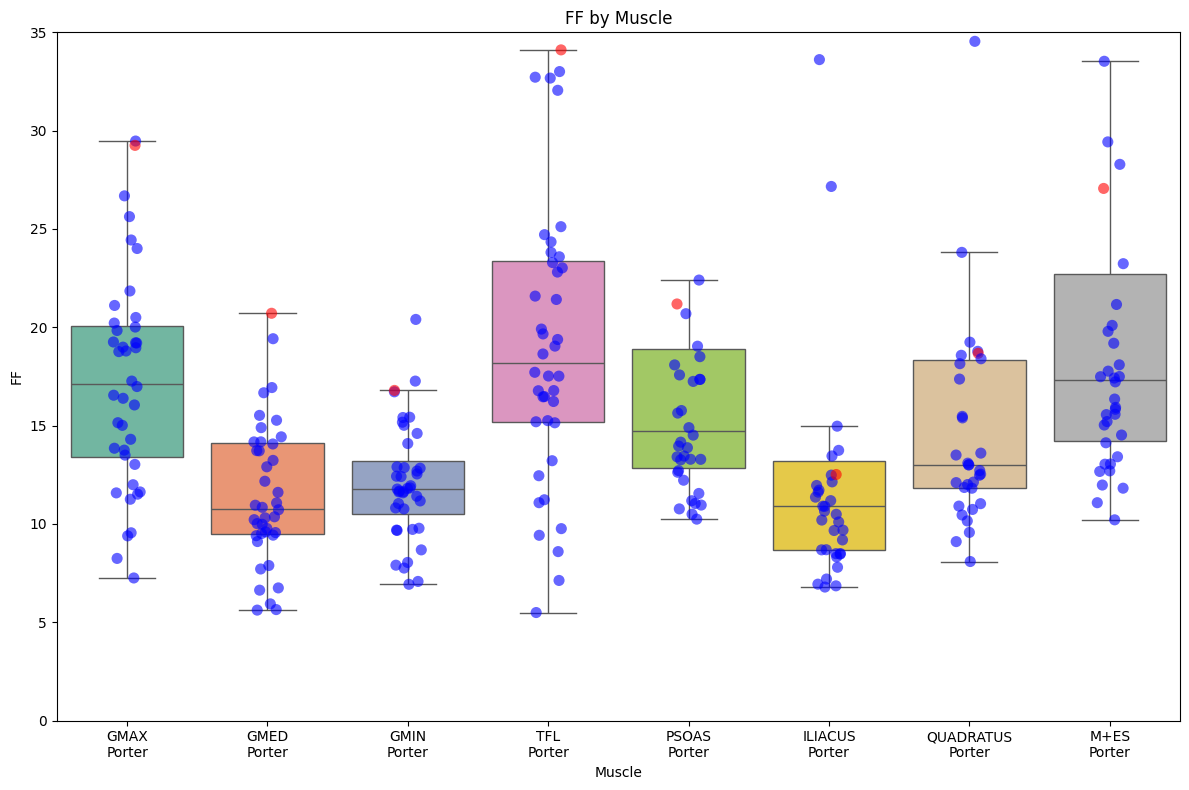

C:\Users\marti\AppData\Local\Temp\ipykernel_24256\39535366.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Muscle', y=var, data=df, showfliers=False, palette='Set2', ax=ax)
C:\Users\marti\AppData\Local\Temp\ipykernel_24256\39535366.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{m}\nPorter" for m in muscle_order])


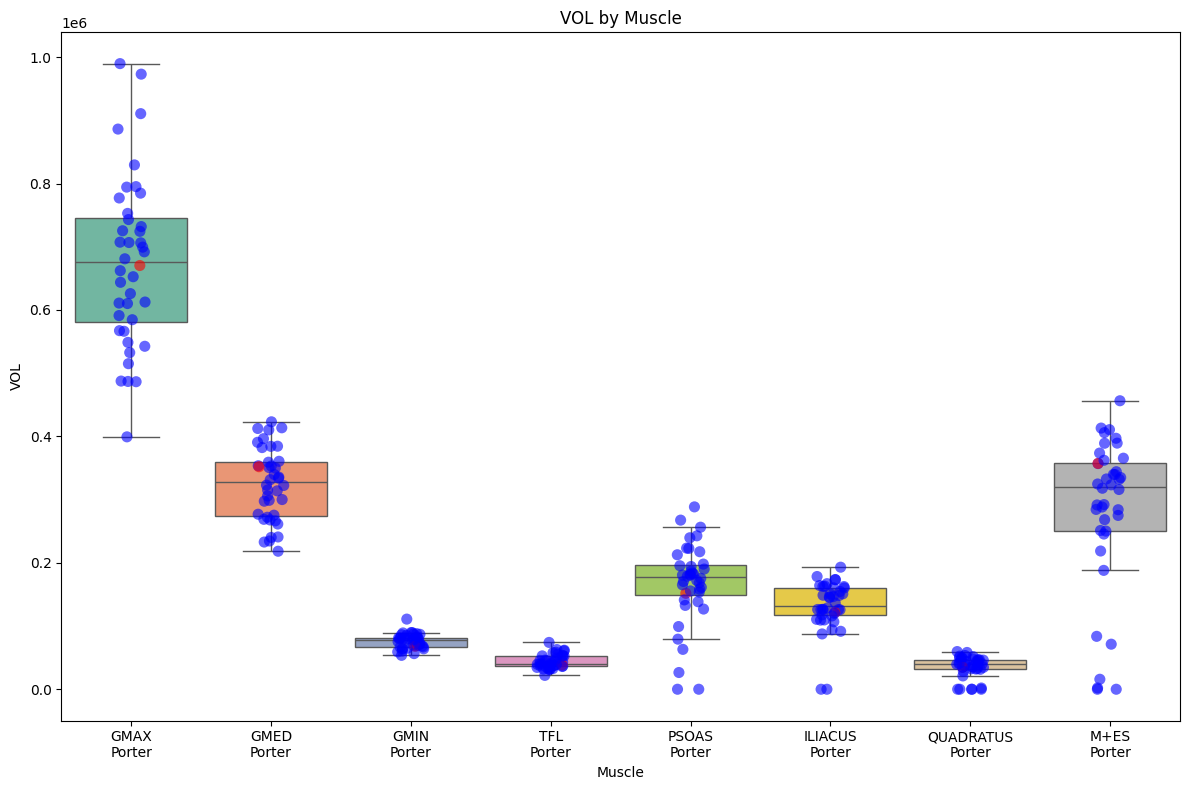

C:\Users\marti\AppData\Local\Temp\ipykernel_24256\39535366.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Muscle', y=var, data=df, showfliers=False, palette='Set2', ax=ax)
C:\Users\marti\AppData\Local\Temp\ipykernel_24256\39535366.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{m}\nPorter" for m in muscle_order])


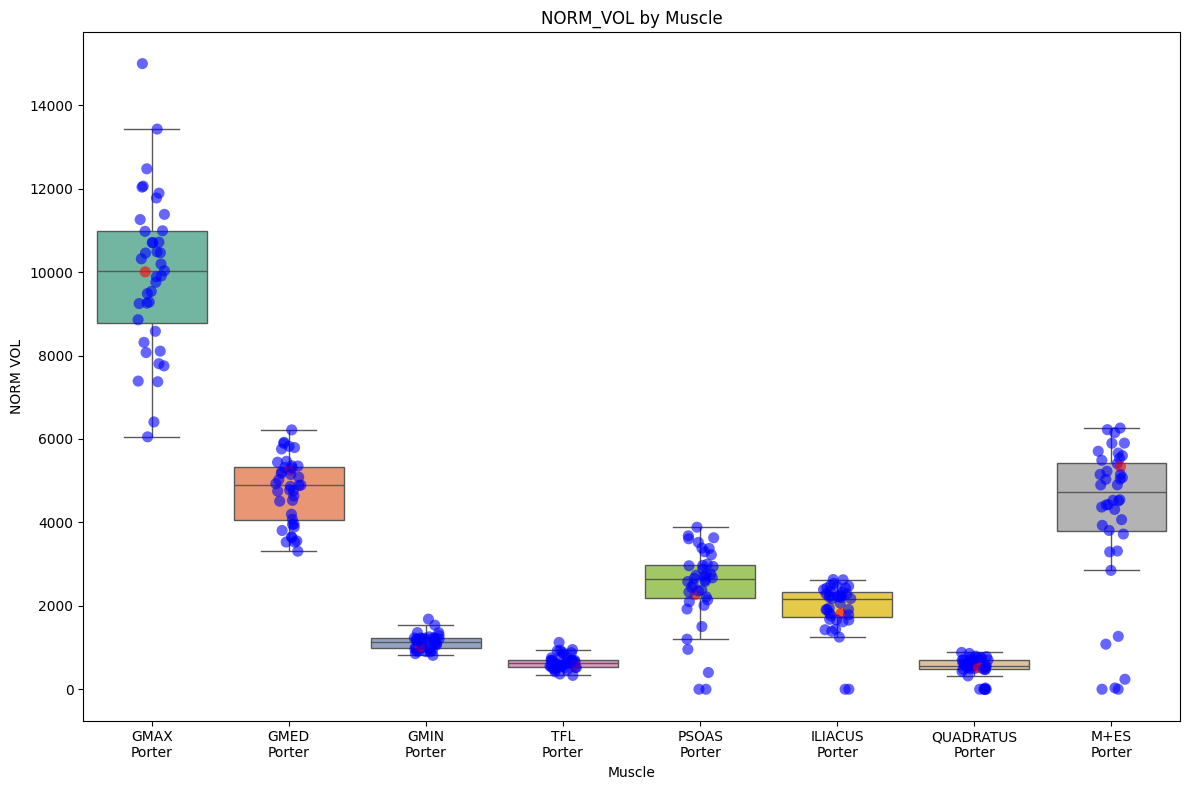

C:\Users\marti\AppData\Local\Temp\ipykernel_24256\39535366.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Muscle', y=var, data=df, showfliers=False, palette='Set2', ax=ax)
C:\Users\marti\AppData\Local\Temp\ipykernel_24256\39535366.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{m}\nPorter" for m in muscle_order])


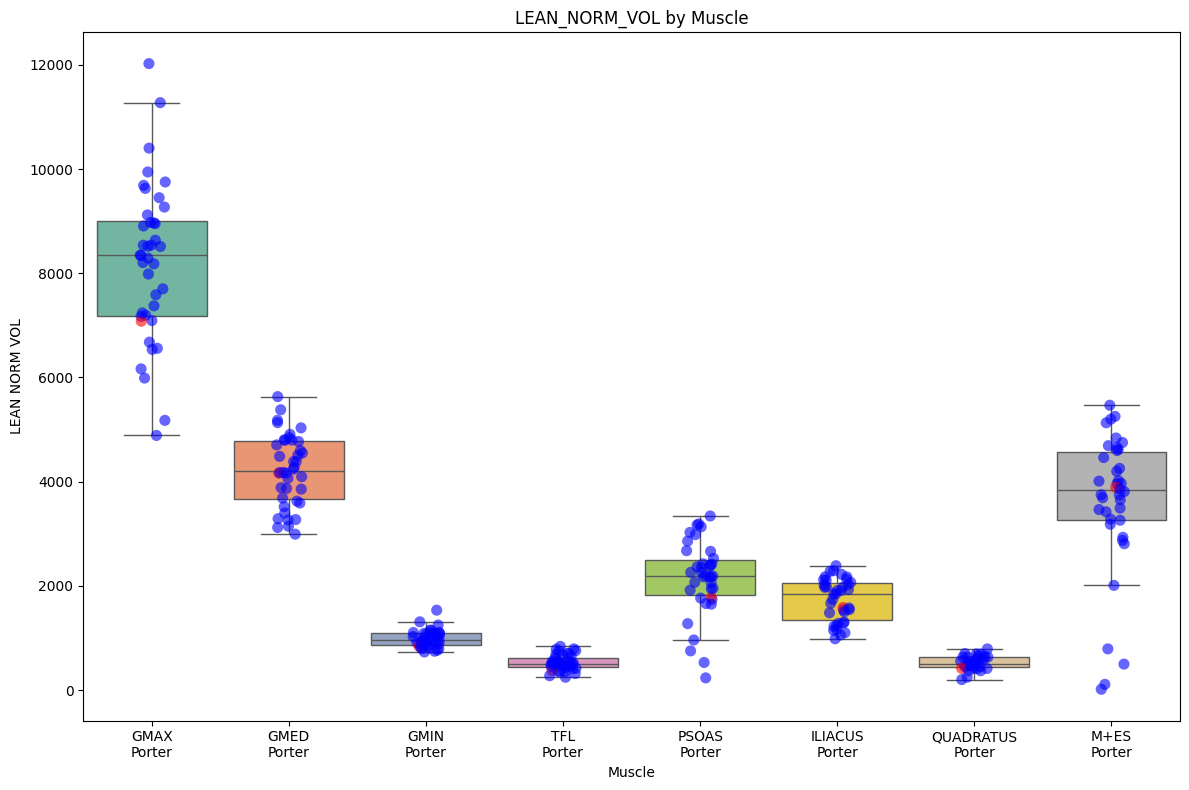

C:\Users\marti\AppData\Local\Temp\ipykernel_24256\39535366.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Muscle', y=var, data=df, showfliers=False, palette='Set2', ax=ax)
C:\Users\marti\AppData\Local\Temp\ipykernel_24256\39535366.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{m}\nPorter" for m in muscle_order])


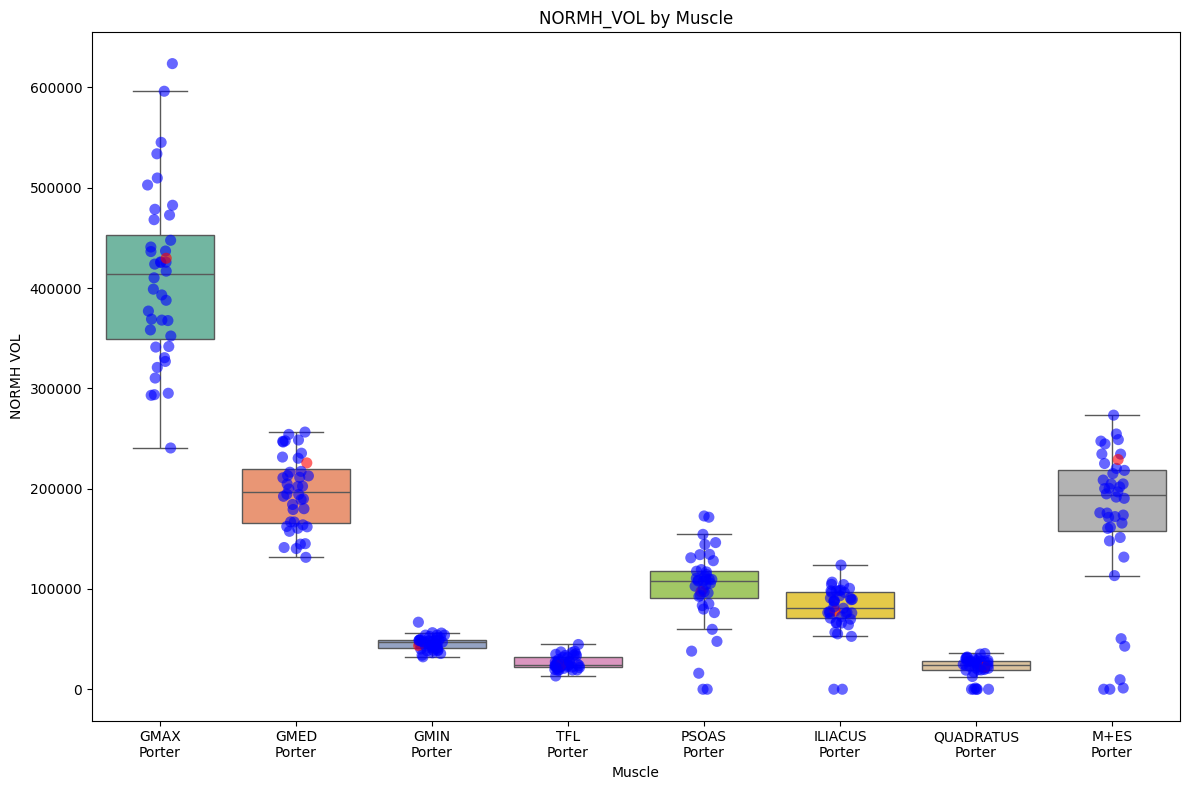

C:\Users\marti\AppData\Local\Temp\ipykernel_24256\39535366.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Muscle', y=var, data=df, showfliers=False, palette='Set2', ax=ax)
C:\Users\marti\AppData\Local\Temp\ipykernel_24256\39535366.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{m}\nPorter" for m in muscle_order])


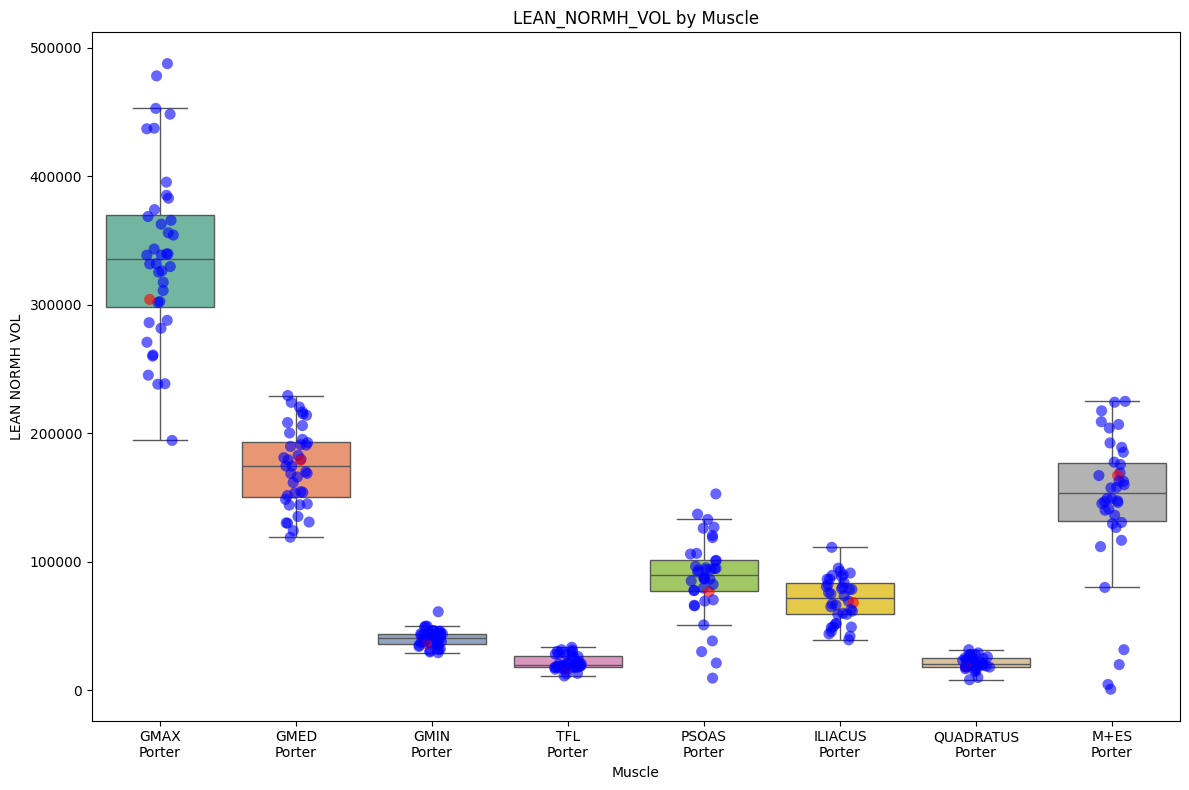

C:\Users\marti\AppData\Local\Temp\ipykernel_24256\39535366.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Muscle', y=var, data=df, showfliers=False, palette='Set2', ax=ax)
C:\Users\marti\AppData\Local\Temp\ipykernel_24256\39535366.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{m}\nPorter" for m in muscle_order])


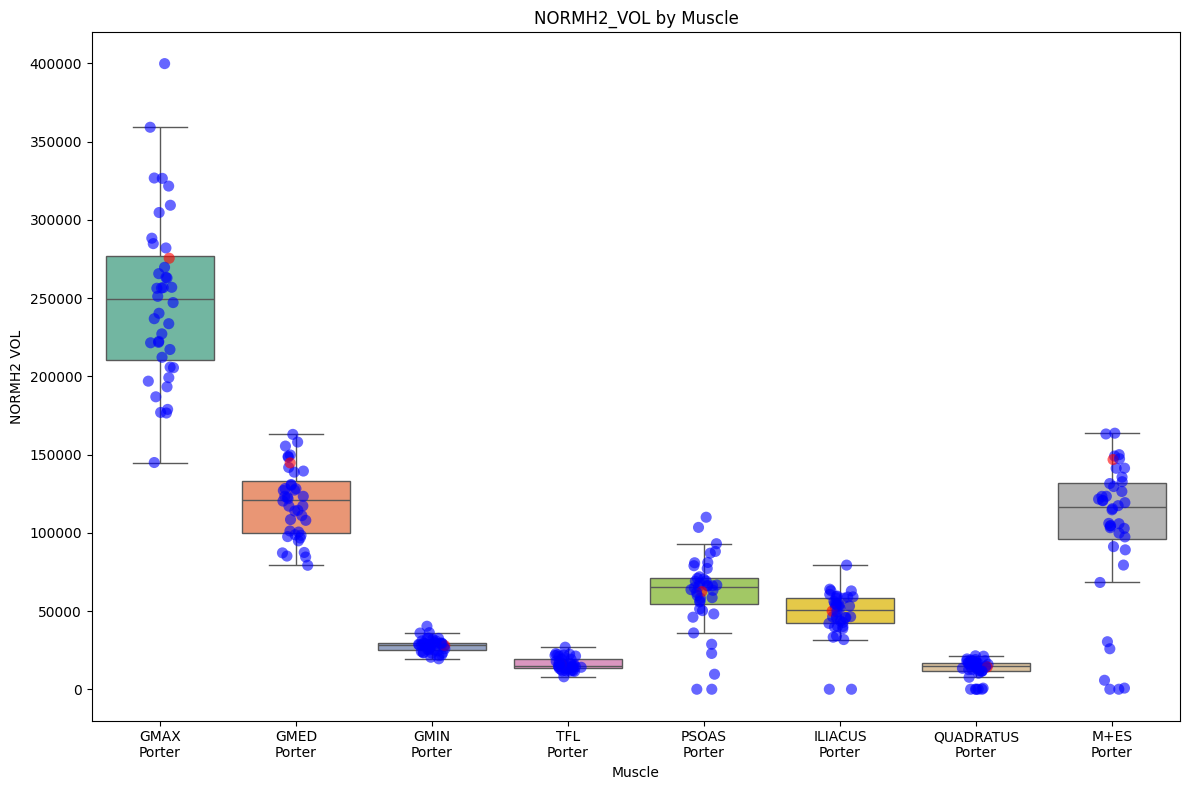

C:\Users\marti\AppData\Local\Temp\ipykernel_24256\39535366.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Muscle', y=var, data=df, showfliers=False, palette='Set2', ax=ax)
C:\Users\marti\AppData\Local\Temp\ipykernel_24256\39535366.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{m}\nPorter" for m in muscle_order])


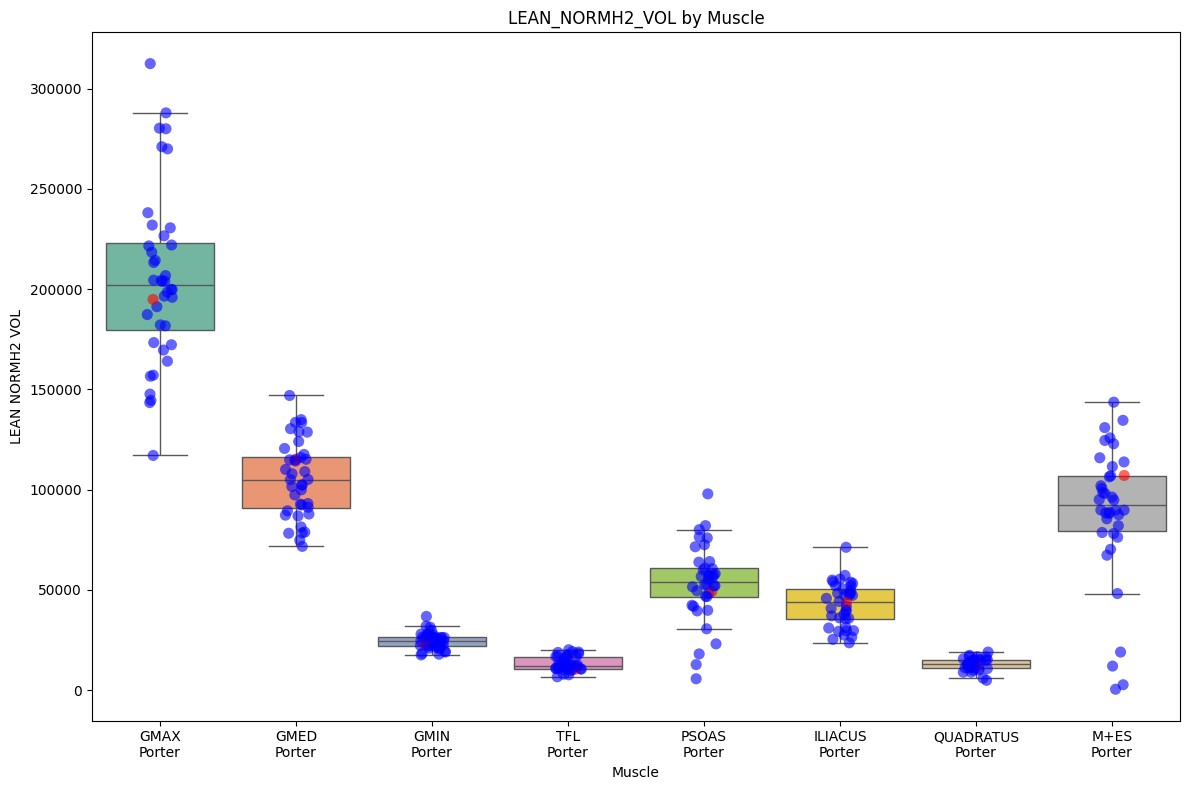

C:\Users\marti\AppData\Local\Temp\ipykernel_24256\39535366.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Muscle', y='FF', data=all_melted, showfliers=False, palette='Set2')


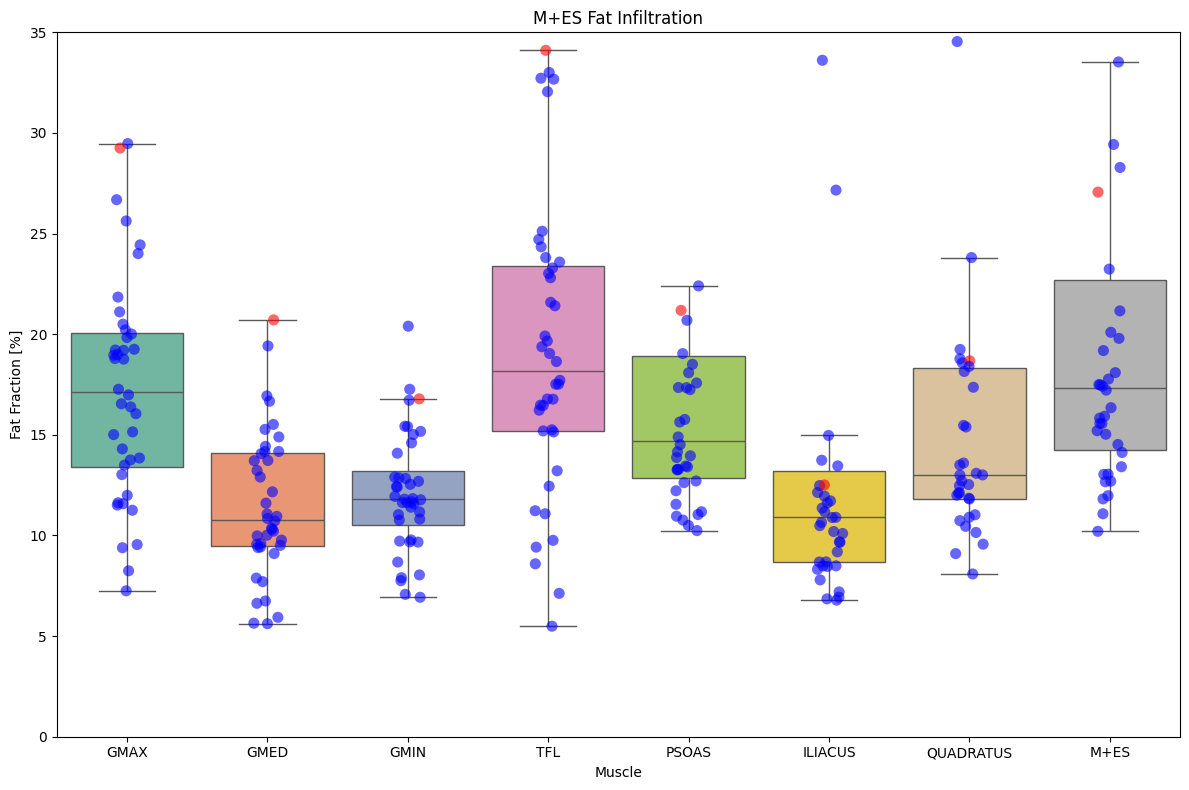

In [64]:

variables = ['FF', 'VOL', 'NORM_VOL', 'LEAN_NORM_VOL', 'NORMH_VOL', 'LEAN_NORMH_VOL', 'NORMH2_VOL', 'LEAN_NORMH2_VOL']
melted_dfs = {
    'FF': all_melted[['Muscle', 'FF', 'Sex', 'Group']],
    'VOL': vol_melted.join(repeated_info),
    'NORM_VOL': nvol_melted.join(repeated_info),
    'LEAN_NORM_VOL': lnvol_melted.join(repeated_info),
    'NORMH_VOL': nhvol_melted.join(repeated_info),
    'LEAN_NORMH_VOL': lnhvol_melted.join(repeated_info),
    'NORMH2_VOL': nh2vol_melted.join(repeated_info),
    'LEAN_NORMH2_VOL': lnh2vol_melted.join(repeated_info)
}

for var in variables:
    df = melted_dfs[var]
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.boxplot(x='Muscle', y=var, data=df, showfliers=False, palette='Set2', ax=ax)
    sns.stripplot(x='Muscle', y=var, data=df, hue='Sex',
                  palette={'Male': 'blue', 'Female': 'red'}, alpha=0.6, jitter=True, size=8,
                  marker='o' if filtered_data['Sex'].iloc[0] == 'Male' else 'X', dodge=False, ax=ax)
    ax.set_ylabel(var.replace('_', ' '))
    ax.set_title(f'{var} by Muscle')
    ax.set_xticklabels([f"{m}\nPorter" for m in muscle_order])
    if var == 'FF':
        ax.set_ylim(0, 35)
    if ax.get_legend():
        ax.get_legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"boxplot_{var.lower()}_all_muscles_by_group.png"))
    plt.show()
# Plot box plots for fat fraction:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x='Muscle', y='FF', data=all_melted, showfliers=False, palette='Set2')
sns.stripplot(x='Muscle', y='FF', data=all_melted, hue='Sex',
                palette={'Male': 'blue', 'Female': 'red'}, alpha=0.6, jitter=True, size=8,
                marker='o' if filtered_data['Sex'].iloc[0] == 'Male' else 'X', dodge=False)
ax.set_ylabel('Fat Fraction [%]')
ax.set_title(f'{muscle} Fat Infiltration')
ax.set_ylim(0, 35)
if i == 0:
    ax.legend(title='Sex')
else:
    ax.get_legend().remove()
plt.tight_layout()
plt.savefig(os.path.join(output_path, "boxplot_ff_all_muscles_by_group.png"))
plt.show()



C:\Users\marti\AppData\Local\Temp\ipykernel_24256\2291546559.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=f'LEAN_NORM_VOL_{muscle}', data=filtered_data, showfliers=False, palette='Set2')


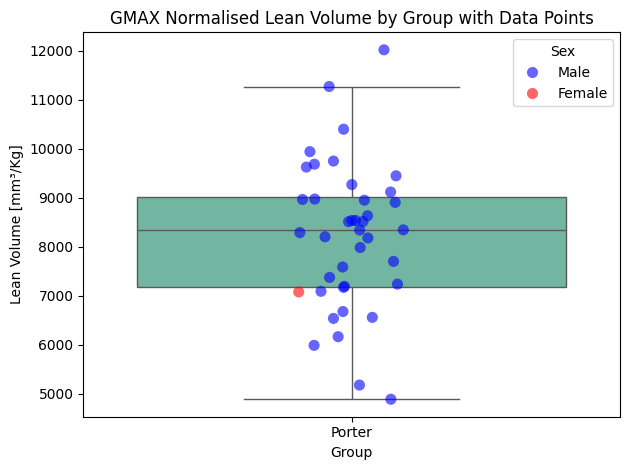

C:\Users\marti\AppData\Local\Temp\ipykernel_24256\2291546559.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=f'LEAN_NORM_VOL_{muscle}', data=filtered_data, showfliers=False, palette='Set2')


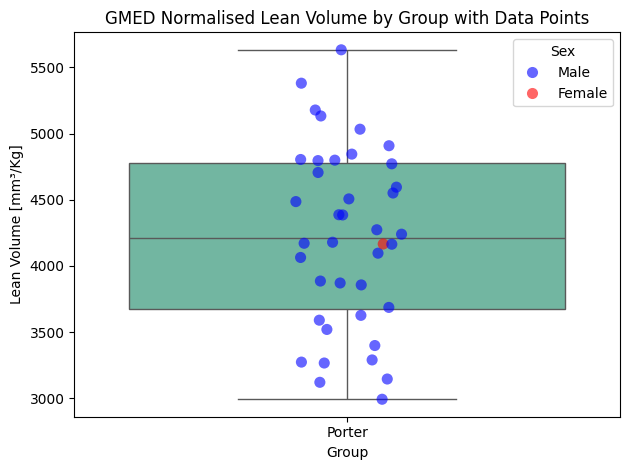

C:\Users\marti\AppData\Local\Temp\ipykernel_24256\2291546559.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=f'LEAN_NORM_VOL_{muscle}', data=filtered_data, showfliers=False, palette='Set2')


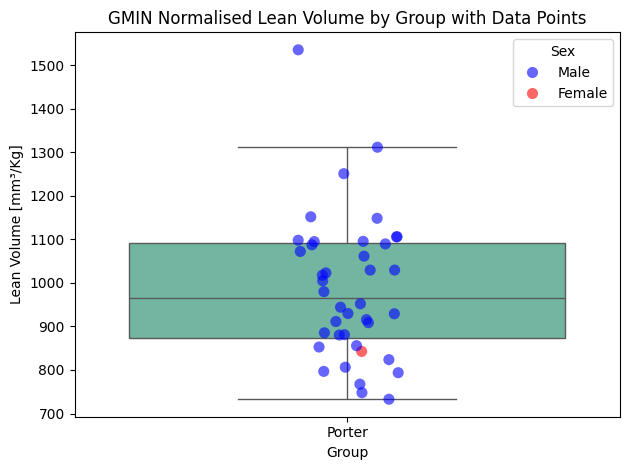

C:\Users\marti\AppData\Local\Temp\ipykernel_24256\2291546559.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=f'LEAN_NORM_VOL_{muscle}', data=filtered_data, showfliers=False, palette='Set2')


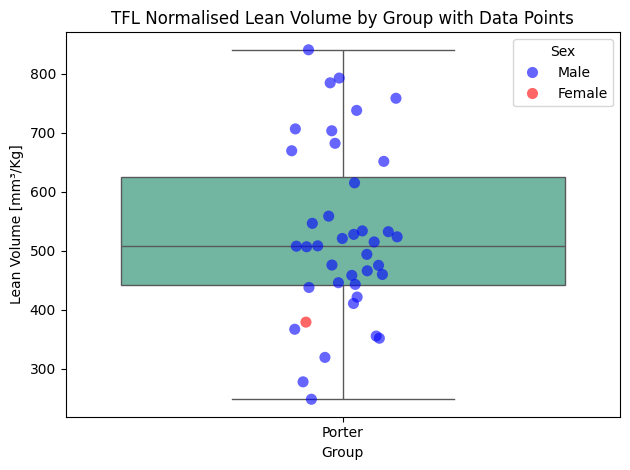

In [53]:
for muscle in ['GMAX', 'GMED', 'GMIN', 'TFL']:
    sns.boxplot(x='Group', y=f'LEAN_NORM_VOL_{muscle}', data=filtered_data, showfliers=False, palette='Set2')
    sns.stripplot(x='Group', y=f'LEAN_NORM_VOL_{muscle}', data=filtered_data, hue='Sex', 
                  palette={'Male': 'blue', 'Female': 'red'}, alpha=0.6, jitter=True, size=8, 
                  marker='o' if filtered_data['Sex'].iloc[0] == 'Male' else 'X')
    plt.ylabel('Lean Volume [mm³/Kg]')
    plt.title(f'{muscle} Normalised Lean Volume by Group with Data Points')
    #plt.ylim(0, 25)
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"boxplot_lean_vol_{muscle}_by_group.png"))
    plt.show()
    plt.close()


C:\Users\Martin\AppData\Local\Temp\ipykernel_26536\1001115094.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=variable, data=filtered_data, showfliers=False, palette='Set2')


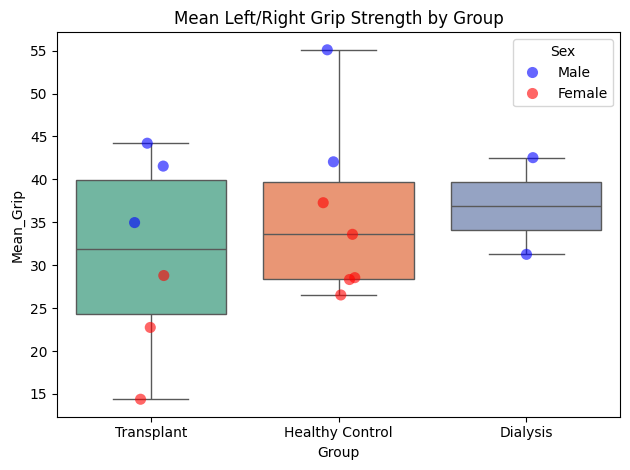

In [ ]:
filtered_data['Mean_Izquierda'] = filtered_data[['Izquierda-1', 'Izquierda-2', 'Izquierda-3']].mean(axis=1)
filtered_data['Mean_Derecha'] = filtered_data[['Derecha-1', 'Derecha-2', 'Derecha-3']].mean(axis=1)
filtered_data['Max_Izquierda'] = filtered_data[['Izquierda-1', 'Izquierda-2', 'Izquierda-3']].max(axis=1)
filtered_data['Max_Derecha'] = filtered_data[['Derecha-1', 'Derecha-2', 'Derecha-3']].max(axis=1)
filtered_data['Mean_Grip'] = (filtered_data['Mean_Izquierda'] + filtered_data['Mean_Derecha']) / 2
filtered_data['Max_Grip'] = (filtered_data['Max_Izquierda'] + filtered_data['Max_Derecha']) / 2
variables_to_plot = ['Mean_Grip']#, 'Max_Grip']
# Create boxplots for Mean_Grip and Max_Grip by groups with points
for variable in variables_to_plot:
    sns.boxplot(x='Group', y=variable, data=filtered_data, showfliers=False, palette='Set2')
    sns.stripplot(x='Group', y=variable, data=filtered_data, hue='Sex', 
                  palette={'Male': 'blue', 'Female': 'red'}, alpha=0.6, jitter=True, size=8, 
                  marker='o' if filtered_data['Sex'].iloc[0] == 'Male' else 'X')
    plt.ylabel(f'{variable}')
    plt.title(f'Mean Left/Right Grip Strength by Group')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"boxplot_{variable}_by_group.png"))
    plt.show()
    plt.close()



Muscle: GMAX, R²: 0.18, Slope: -0.2237, R: -0.4220


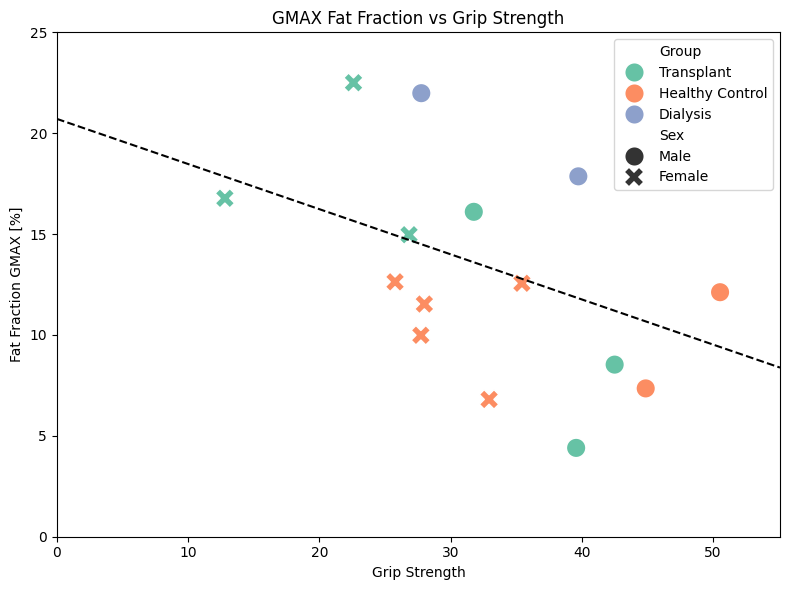

Muscle: GMED, R²: 0.30, Slope: -0.1675, R: -0.5454


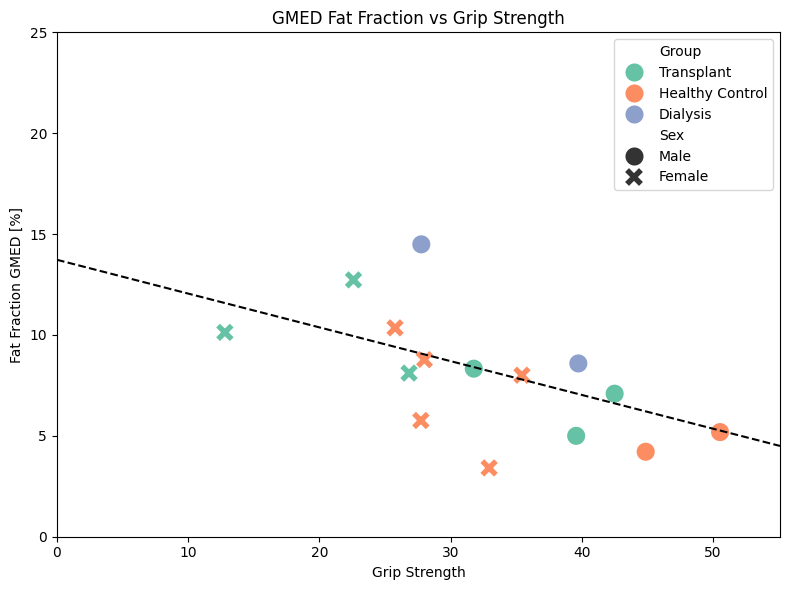

Muscle: GMIN, R²: 0.10, Slope: -0.1776, R: -0.3092


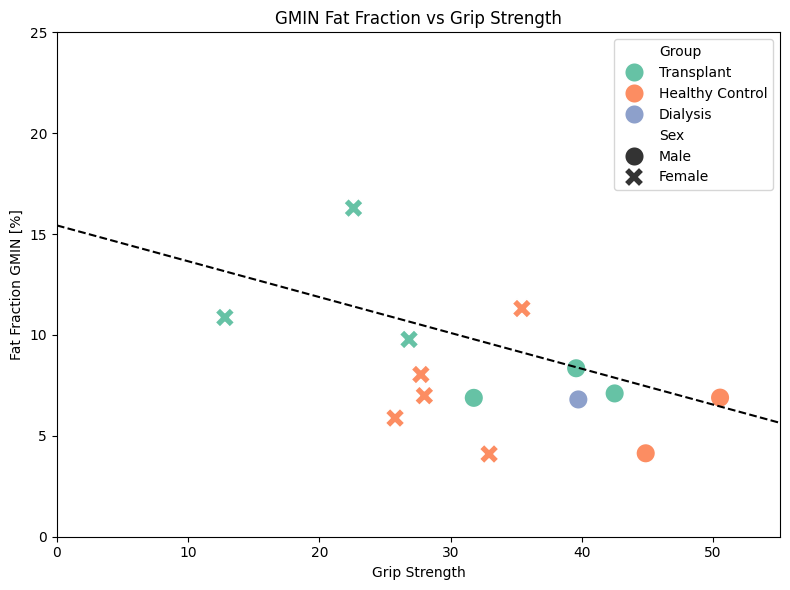

Muscle: TFL, R²: 0.00, Slope: -0.0038, R: -0.0097


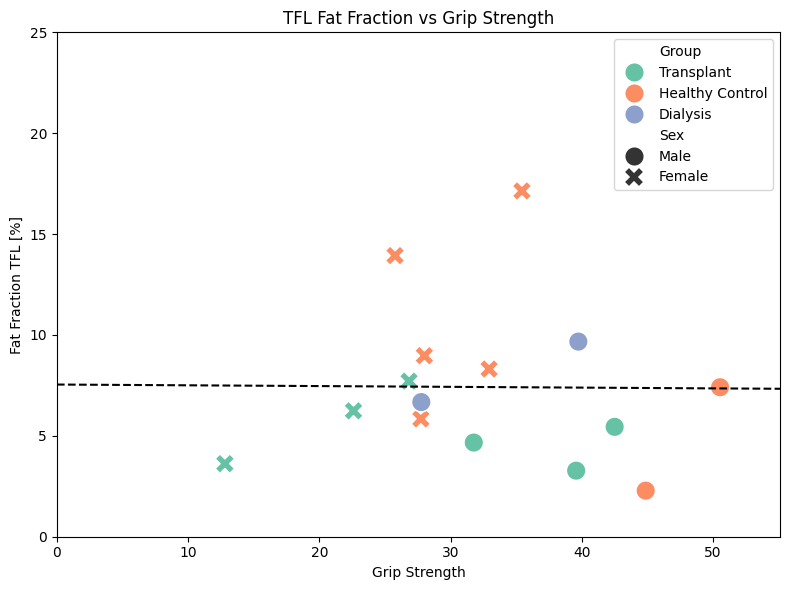

In [ ]:
for muscle in ['GMAX', 'GMED', 'GMIN', 'TFL']:
    # Fit a linear regression model
    slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_data['Mean_Grip'], filtered_data[f'FF_{muscle}'])
    # Add the regression line to the plot
    x_vals = np.linspace(0, filtered_data['Mean_Grip'].max(), 100)
    y_vals = slope * x_vals + intercept
    print(f"Muscle: {muscle}, R²: {r_value**2:.2f}, Slope: {slope:.4f}, R: {r_value:.4f}")
   # print(x_vals)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='Mean_Izquierda', y=f'FF_{muscle}', data=filtered_data, hue='Group', style='Sex', palette='Set2', s=200)
    plt.plot(x_vals, y_vals, color='black', linestyle='--', label=f'Linear Fit (R²={r_value**2:.2f})')
    plt.xlabel('Grip Strength')
    plt.ylabel(f'Fat Fraction {muscle} [%]')
    plt.xlim(0, filtered_data['Mean_Grip'].max())
    plt.ylim(0, 25)
    #plt.legend()
    plt.title(f'{muscle} Fat Fraction vs Grip Strength')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"scatter_ff_{muscle}_vs_grip_strength.png"))
    plt.show()

Index(['Var1', 'group', 'age_years', 'sex', 'weight_kg', 'height_cm', 'bmi',
       'ffMeanSides_1', 'ffMeanSides_2', 'ffMeanSides_3', 'ffMeanSides_4',
       'meanVolume_mm3_1', 'meanVolume_mm3_2', 'meanVolume_mm3_3',
       'meanVolume_mm3_4', 'normMeanVolume_mm3_1', 'normMeanVolume_mm3_2',
       'normMeanVolume_mm3_3', 'normMeanVolume_mm3_4', 'meanLeanVolume_mm3_1',
       'meanLeanVolume_mm3_2', 'meanLeanVolume_mm3_3', 'meanLeanVolume_mm3_4',
       'normMeanLeanVolume_mm3_1', 'normMeanLeanVolume_mm3_2',
       'normMeanLeanVolume_mm3_3', 'normMeanLeanVolume_mm3_4', 'Study ID',
       'sex_glutes', 'age_years_glutes', 'Weight (kg)', 'Height (cm)',
       'group_glutes', 'bmi_glutes', 'LBM', 'SubjectID', 'Unnamed: 9', 'LLT',
       'RLT', 'LASIS', 'RASIS', 'Physical Activity Index',
       'h physical activity/wk before using app', 'Physical Activity History',
       'Gender_ff', 'Age_ff', 'Weight (kg)_ff', 'Height (cm)_ff', 'Group_ff',
       'Bmi_ff', 'LBM_ff', 'Gender_vol', 'Age

C:\Users\Martin\AppData\Local\Temp\ipykernel_26536\3585763710.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y=variable, data=cto5k_pd_copy, showfliers=False, palette='Set2')
C:\Users\Martin\AppData\Local\Temp\ipykernel_26536\3585763710.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=f'FF_{variable}', data=filtered_data, showfliers=False, palette='Set2')
C:\Users\Martin\AppData\Local\Temp\ipykernel_26536\3585763710.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y=variable, data=cto5k_pd_cop

ValueError: Could not interpret value `FF_GMAX_nvol` for `y`. An entry with this name does not appear in `data`.

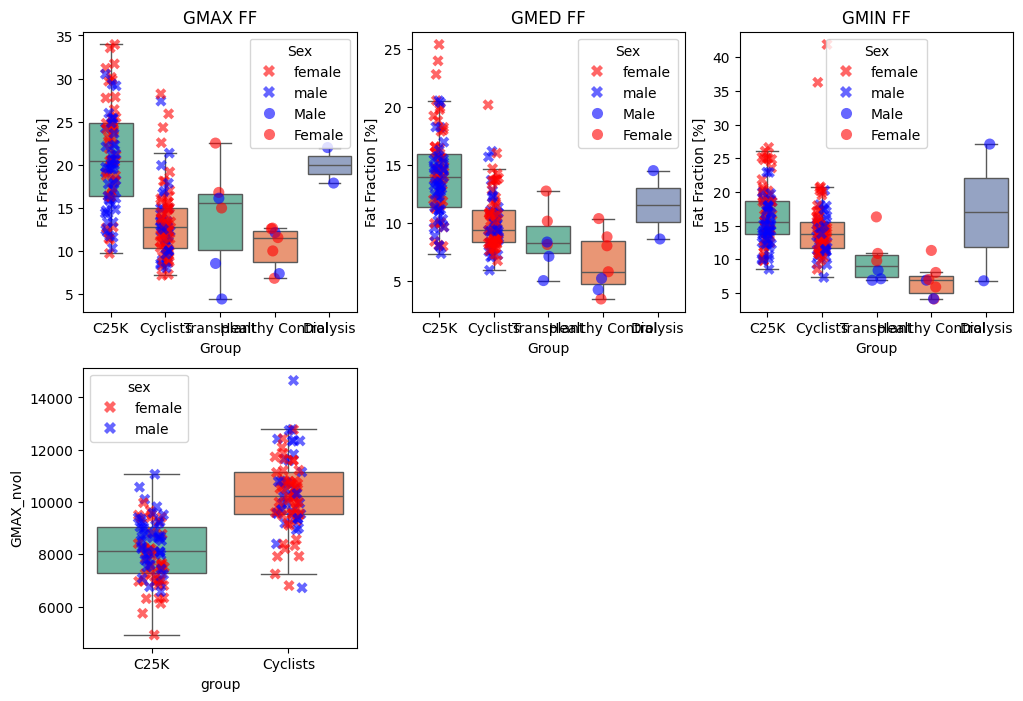

In [ ]:
# Now compare to groups from a different study (warning: different protocol)
results_cto5k_filename = "D:/Work/Publications/2025_CoreScore/DataAnalysis/CoreScore/merged_data.csv"
cto5k_pd = pd.read_csv(results_cto5k_filename)
# Variable names:
names_ff_to_merge = [
    'ffMeanSides_1', 'ffMeanSides_2', 'ffMeanSides_3', 'ffMeanSides_4', 'GMAX', 'GMED', 'GMIN']
names_vol_to_merge = [
    'meanVolume_mm3_1', 'meanVolume_mm3_2', 'meanVolume_mm3_3', 'meanVolume_mm3_4', 'GMAX_vol', 'GMED_vol', 'GMIN_vol']
names_nvol_to_merge = [
    'normMeanVolume_mm3_1', 'normMeanVolume_mm3_2', 'normMeanVolume_mm3_3', 'normMeanVolume_mm3_4', 'GMAX_nvol', 'GMED_nvol', 'GMIN_nvol']
names_lvol_to_merge = [
    'meanLeanVolume_mm3_1', 'meanLeanVolume_mm3_2', 'meanLeanVolume_mm3_3', 'meanLeanVolume_mm3_4', 'GMAX_lvol', 'GMED_lvol', 'GMIN_lvol']
names_nlvol_to_merge = [
    'normMeanLeanVolume_mm3_1', 'normMeanLeanVolume_mm3_2', 'normMeanLeanVolume_mm3_3', 'normMeanLeanVolume_mm3_4', 'GMAX_nlvol', 'GMED_nlvol', 'GMIN_nlvol']

# Set up the figure
plt.figure(figsize=(12, 8))
variables_to_plot = ['GMAX', 'GMED', 'GMIN', 'GMAX_nvol', 'GMED_nvol', 'GMIN_nvol']
variables_names_for_titles = {
    'GMAX': 'GMAX FF',
    'GMED':  'GMED FF',
    'GMIN':  'GMIN FF',
    'GMAX_nvol': 'GMAX Normalised Volume',
    'GMED_nvol': 'GMED Normalised Volume',
    'GMIN_nvol': 'GMIN Normalised Volume'
}
ylabel_names = {
    'GMAX': 'Fat Fraction [%]',
    'GMED':  'Fat Fraction [%]',
    'GMIN': 'Fat Fraction [%]',
    'GMAX_nvol': 'Normalised Volume [mm^3/Kg]',
    'GMED_nvol': 'Normalised Volume [mm^3/Kg]',
    'GMIN_nvol': 'Normalised Volume [mm^3/Kg]',
}

#Equise both measurements:
offset_protocols = -2
cto5k_pd_copy = cto5k_pd.copy()
cto5k_pd_copy['GMAX'] = cto5k_pd_copy['GMAX'] + offset_protocols
cto5k_pd_copy['GMED'] = cto5k_pd_copy['GMED'] + offset_protocols
cto5k_pd_copy['GMIN'] = cto5k_pd_copy['GMIN'] + offset_protocols
print(cto5k_pd_copy.columns)
# Plot violin plots with individual dots for each variable
for i, variable in enumerate(variables_to_plot, 1):
    plt.subplot(2, 3, i)  # Create a subplot grid
    #sns.violinplot(x='group', y=variable, data=cto5k_pd_copy, palette='muted', inner=None, hue='group', split=False)
    sns.boxplot(x='group', y=variable, data=cto5k_pd_copy, showfliers=False, palette='Set2')
    sns.stripplot(x='group', y=variable, data=cto5k_pd_copy, hue='sex', 
                  palette={'male': 'blue', 'female': 'red'}, alpha=0.6, jitter=True, size=8, 
                  marker='o' if cto5k_pd_copy['sex'].iloc[0] == 'male' else 'X')
    #sns.stripplot(x='group', y=variable, data=cto5k_pd_copy, color='black', alpha=0.6, jitter=True)
    #sns.violinplot(x='Group', y='FF_GMAX', data=filtered_data, palette='muted', inner=None)
    sns.boxplot(x='Group', y=f'FF_{variable}', data=filtered_data, showfliers=False, palette='Set2')
    sns.stripplot(x='Group', y=f'FF_{variable}', data=filtered_data, hue='Sex', 
                  palette={'Male': 'blue', 'Female': 'red'}, alpha=0.6, jitter=True, size=8, 
                  marker='o' if filtered_data['Sex'].iloc[0] == 'Male' else 'X')
    plt.title(f'{variables_names_for_titles[variable]}')
    plt.xlabel('Group')
    plt.ylabel(f'{ylabel_names[variable]}')

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig(output_path + "violin_plots_core_score_group.png")
plt.show()